<a href="https://colab.research.google.com/github/ArvindReddyC/Digital_Twin_self/blob/main/Prediction%20Model/Consumption_KNN_model/v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model required

In [1]:
import pandas as  pd
import numpy as np
from json import JSONEncoder
import requests
import matplotlib.pyplot as plt 
import time

from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
import sklearn
import math



### Notes 

1. We are predicting both the production and the consumtion when we are given the 

#### Doubts 

1. How many parameters to use .? Suggested is as many as possible cos more parameters more good the data.
2. Should I take time into consideration .? try doing with and without time and pick which is better. 

### Functions 

### DateTimeEncoder

In [2]:
class DateTimeEncoder(JSONEncoder):
        #Override the default method
        def default(self, obj):
            if isinstance(obj, (datetime.date, datetime.datetime)):
                return obj.isoformat()

### get_data

In [3]:
def get_data(id,attri,start_date , end_date):
    ''' 
    Edit this if your running a cron Job 
    queryTimeDiff = datetime.timedelta(minutes=90)
    endDate = datetime.datetime.now()
    startDate = datetime.datetime.now() - queryTimeDiff
    '''
    
    #Change the start data and End Data for longer duration 
    query = {'id':id,'attributes':attri,'startDate':start_date,'endDate':end_date}
    query = DateTimeEncoder().encode(query)
    query = eval(query)
    response = requests.get('http://54.206.42.58:8006/api/v2/historicalData/getObjectAttributeHistoricalData', params=query)

    data = response.json()
    #print(data)
    exportedData = data["data"]["ObjectData"]
    df = pd.DataFrame(exportedData)

    #print(df.head(5))
    pivoted = df.pivot( index= 'measurementtimestamp' , columns='attributeserviceid' , values= 'value' )
    pivoted.replace(np.nan, 0 , inplace=True)
    #pivoted.rename( columns={ 'Irradiance Global (W/m^2)': 'irradiance' , 'Back-of-Module Temperature 2 (deg C)' : 'backtmp2' , 'Active Power' : 'activepower'   } , inplace=True )
    
    return pivoted


In [8]:
df = get_data('WP_HVW_SWB.1J07_PM_WestFdr,WP_SF_MVPS4.WS1','Active Power,Ambient Temperature Celsius,AVG in-plane irradiance,Rainfall (mm),Irradiance Global (W/m^2),Back-of-Module Temperature 2 (deg C),Back-of-Module Temperature (deg C),Irradiance Plane-of-Array (W/m^2),Weather Atmospheric Pressure,Weather Relative Humidity,Wind Direction (Hour Interval),Wind Speed','2021-01-01 00:00:00' , '2021-12-31 00:00:00')



In [9]:
#drop Weather Atmospheric Pressure , Wind Direction (Hour Interval) 
df

attributeserviceid,AVG in-plane irradiance,Active Power,Ambient Temperature Celsius,Back-of-Module Temperature (deg C),Back-of-Module Temperature 2 (deg C),Irradiance Global (W/m^2),Irradiance Plane-of-Array (W/m^2),Rainfall (mm),Weather Atmospheric Pressure,Weather Relative Humidity,Wind Direction (Hour Interval),Wind Speed
measurementtimestamp,,,,,,,,,,,,
2021-01-01T00:00:00.000Z,1222,0,23.6,37.7,47.1,986,1222,3481.8,1007,64,138,4
2021-01-01T00:15:00.000Z,1221,0,24,34.2,44.1,1016,1221,3481.8,1007,63,108,2
2021-01-01T00:30:00.000Z,1245,0,23.8,32.2,42.7,1060,1245,3481.8,1007,62,105,6
2021-01-01T00:45:00.000Z,1259,0,24.4,32.4,43.2,1102,1259,3481.8,1007,61,79,3
2021-01-01T01:00:00.000Z,924,0,24.8,31.6,42.7,827,924,3481.8,1007,60,81,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30T23:40:00.000Z,0,2405.4970703125,34.79999923706055,40.099998474121094,44.5,948,1204,6479.7998046875,998,20,309,5
2021-12-30T23:45:00.000Z,1201,2487.380859375,35,40.79999923706055,45.400001525878906,963,1201,6479.7998046875,998,20,296,9
2021-12-30T23:50:00.000Z,0,2430.73095703125,35,40.29999923706055,44.599998474121094,979,1207,6479.7998046875,998,20,291,4


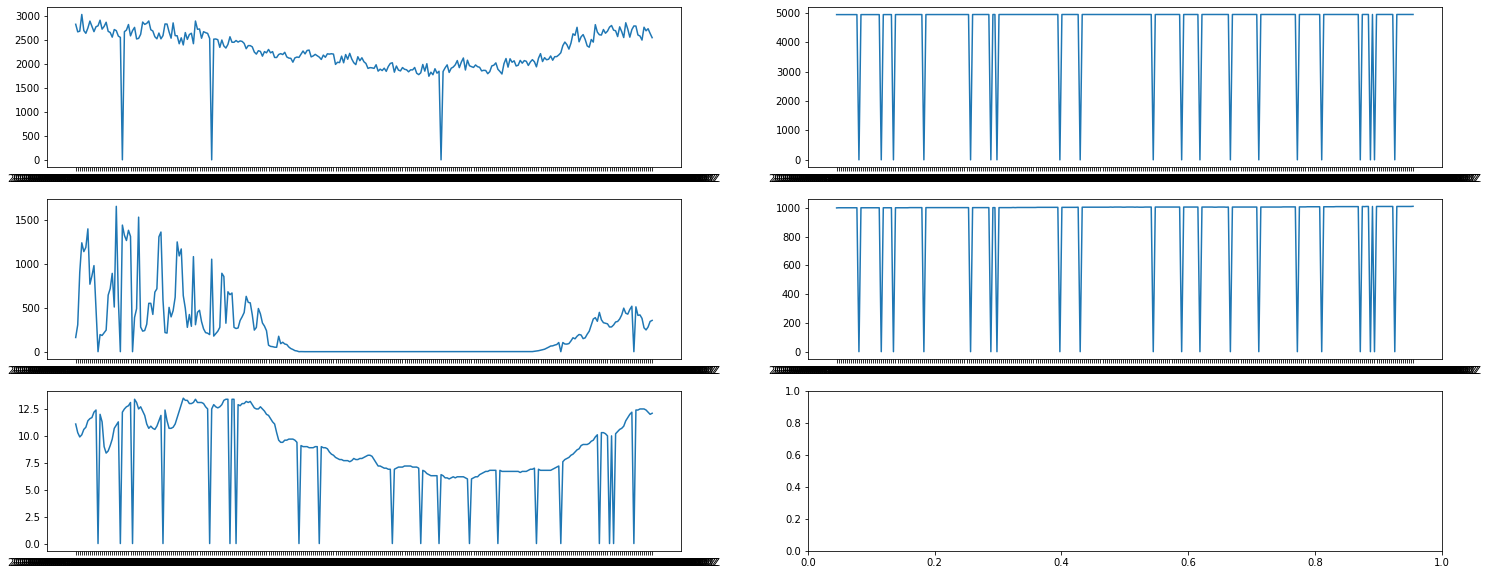

In [7]:

fig,ax =  plt.subplots( 3,2  , figsize = (25,10))
ax[0,0].plot( df.index , df['Active Power'].astype(float)  )
ax[0,1].plot( df.index , df['Rainfall (mm)'].astype(float)  )
ax[1,0].plot( df.index , df['Irradiance Global (W/m^2)'].astype(float)  )
ax[1,1].plot( df.index , df['Weather Atmospheric Pressure'].astype(float)  )
ax[2,0].plot( df.index , df['Ambient Temperature Celsius'].astype(float)  )


In [93]:
(df.astype(float) == 0.0).sum()

attributeserviceid
AVG in-plane irradiance                 31876
Active Power                            35172
Ambient Temperature Celsius              3378
Back-of-Module Temperature (deg C)       2071
Back-of-Module Temperature 2 (deg C)     2071
Irradiance Global (W/m^2)               22822
Irradiance Plane-of-Array (W/m^2)       22781
Rainfall (mm)                            3559
Weather Atmospheric Pressure             3378
Weather Relative Humidity                3378
Wind Direction (Hour Interval)           3378
Wind Speed                               3933
dtype: int64

#### Based on the Evidence above we will use 


1.   Active Power 
2.   Back-of-Module Temperature (deg C)
3.   Irradiance Global (W/m^2)
4.   Irradiance Plane-of-Array (W/m^2) 






In [10]:
#Function to build a model given a independent and dependent variables

def main( independent , dependent  ):
    subset_df = df[independent].astype(float)
    print(subset_df.dtypes)
    X_train, X_test, y_train, y_test = train_test_split(subset_df , dependent ,
    test_size=0.25) 
    neigh = KNeighborsRegressor(n_neighbors=100,algorithm='brute')
    neigh.fit(X_train,y_train)
    predictions = neigh.predict(X_test)
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = math.sqrt(mse)
    print(rmse)



In [12]:
main(['Irradiance Global (W/m^2)' , 'Back-of-Module Temperature 2 (deg C)'],df['Active Power'].astype(float))

attributeserviceid
Irradiance Global (W/m^2)               float64
Back-of-Module Temperature 2 (deg C)    float64
dtype: object
881.2679260896701


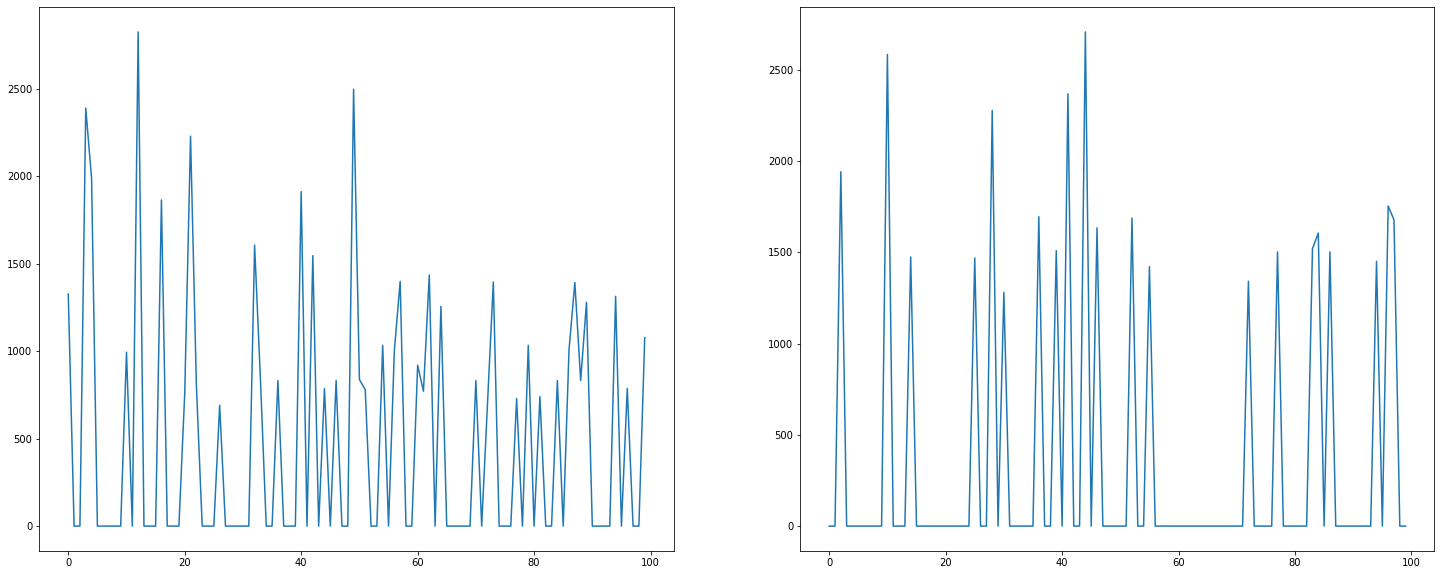

In [70]:
fig,ax =  plt.subplots( 1,2  , figsize = (25,10))
ax[0].plot( list(np.arange(0,(len(y_test))  , 1))[:100]  , list(predictions)[:100] )
ax[1].plot( list(np.arange(0,(len(y_test))  , 1))[:100]  , list(y_test)[:100] )